<a href="https://colab.research.google.com/github/IshaqKHATTAK/Captivate-Caption-generation-for-images/blob/main/data_formating_and_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
from google.colab import files
video = files.upload()

Saving kaggle.json to kaggle.json


In [9]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


#loading the file into google colab

In [10]:

!kaggle datasets download -d shadabhussain/flickr8k


100% 2.13G/2.13G [01:07<00:00, 40.7MB/s]
100% 2.13G/2.13G [01:07<00:00, 33.9MB/s]


In [11]:
!unzip '/content/flickr8k.zip'

Streaming output truncated to the last 5000 lines.
  inflating: flickr_data/Flickr_Data/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846037553_1a1de50709.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846843520_b0e6211478.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847514745_9a35493023.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847615962_c330bded6e.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848266893_9693c66275.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848571082_26454cb981.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848895544_6d06210e9d.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848977044_446a31d86e.jpg  
  inflating: flickr_data/Flickr_Data/Images/2849194983_2968c72832.jpg  
  inflating: flickr_data/Flickr_Data/Images/2850719435_221f15e951.jpg  
  inflating: 

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import tensorflow
import keras
from keras.layers import Dense,Flatten,Activation
import string
import os
import glob
from PIL import Image
from time import time

#preprocessing
Reads image IDs and captions from the file "data/textFiles/tokens.txt" and stores them as a dictionary.

Cleans the text by converting to lower case and removing non-alphabet characters

Stores this cleaned data (as a dictionary) to a new file "data/textFiles/tokens_clean.txt"

In [13]:
from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers import Bidirectional
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical

In [14]:
def readFile (path):
    with open(path) as file:
        data = file.read()
    return data;

In [15]:

# Read captions from the file Flickr8k.token.txt
data = readFile ("/content/flickr_data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
# Split the data into each line, to get a list of captions
captions = data.split('\n')
# Remove the last line since it is blank
captions = captions[:-1]

In [16]:
print("Total number of caption = " + str(len(captions)))

Total number of caption = 40460


In [18]:
captions[0:4] #It says that there is four captions per image.

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .']

In [19]:
len(captions)

40460

In [20]:
# Store the captions in a dictionary
# Each imageID will be mapped to a list of its captions

content = {}

for line in captions:
    imageID, caption = line.split('\t')

    imageID = imageID.split('.')[0]

    # If the imageID doesn't exist in the dictionary, create a blank entry
    if content.get(imageID) is None:
        content[imageID] = []

    # Append the current caption to the list of the corresponding image
    content[imageID].append(caption)

In [22]:
print(content[captions[0].split('.')[0]]) #captions[0].split('.')[0] = image_id

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


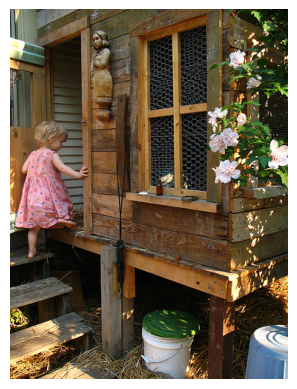

CAPTIONS - 
A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


In [23]:
# Choose a random number, say 50
import cv2
from PIL import Image
IMG_PATH = "/content/flickr_data/Flickr_Data/Images/"
image_id = captions[1].split('.')[0]

img = Image.open(IMG_PATH + image_id + ".jpg")
img = img.convert('RGB')
plt.imshow(img)
plt.axis("off")
plt.show()

print("CAPTIONS - ")
for caption in content[image_id]:
    print(caption)

In [24]:
captions[10].split('.')[0]

'1002674143_1b742ab4b8'

#Clean the data
So upto this point we have data in the dictionary formate as given.

data{'1002674143_1b742ab4b8':['caption 1','catptions 2','captions 3','captions 4']

In [25]:
import re
def clean (data):
    # Convert all characters to lower case
    data = data.lower()

    # Convert all non-alphabet characters to ' '
    data = re.sub("[^a-z]+", " ", data)

    return data


In [26]:
for ID, caption_list in content.items():
    for i in range(len(caption_list)):
        content[ID][i] = clean(content[ID][i])

In [28]:
print(content[captions[1].split('.')[0]][-1])

a little girl in a pink dress going into a wooden cabin 


In [29]:
captions[1].split('.')[0]

'1000268201_693b08cb0e'

#Store the cleaned captions in a file "tokens_clean.txt" for future reference

In [30]:
with open ("/content/flickr_data/Flickr_Data/Flickr_TextData/tokens_clean.txt", "w") as file:
    file.write(str(content))

create vocabulary

In [39]:
vocabulary = set()
for key in content.keys():
        [vocabulary.update(d.split()) for d in content[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8441


save the cleaned ansers and image ids in teken.txt formate

In [43]:
path = '/content/cleaned.txt' #create file with name cleaned.txt

with open(path, 'w') as file:
  for key, caption in content.items():
    count = 0
    for cap in caption:
      file.write(f'{key}' + '.jpg' + f'#{count}\t' + cap + '\n')
      count += 1
